# Train model LSTM to recognize comment generated and original voice of different person **Combined Dataset** 

In [95]:
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import random_split
import torchaudio
from enum import Enum
import pandas as pd
import torch
from src.utils.plot import plot
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [96]:
SAMPLE_RATE = 16000

DATASET_PATH = './dataset/'
DATA_PATH = './data/'
MODEL_SAVE_PATH = './model_save/'

In [97]:
class SiameseNetwork(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers):
		super(SiameseNetwork, self).__init__()
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, 512)

		self.final = nn.Linear(512, 2)

	def forward_once(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

	def forward(self, input1, input2):
		output1 = self.forward_once(input1)
		output2 = self.forward_once(input2)
		return self.final(torch.abs(output1 - output2))

In [98]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform, AudioToTimeSeriesTransform
from src.transform.composite_transformation import CompositeTransformation

train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
		AudioToTimeSeriesTransform( n_fft=256)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		AudioToTimeSeriesTransform( n_fft=256)
	]
)

In [133]:
from src.columns.combined_dataset_column import CombinedDatasetColumn
import librosa

from src.columns.generated_dataset_column import GeneratedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform, AudioToTimeSeriesTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedLSTMSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
					AudioToTimeSeriesTransform( n_fft=256)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

In [100]:

train_df = pd.read_csv(DATASET_PATH + "train_base_dataset.csv")
train_ds = CombinedLSTMSoundDS(train_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=train_transform)

test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = CombinedLSTMSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

In [101]:
DURATION = 3.

In [102]:
import matplotlib.pyplot as plt
def plot_lstm(sample):
	def plot_spec(ax, spec, title):
		ax.set_title(title)
		ax.imshow(spec, origin="lower", aspect="auto")
		ax.invert_yaxis()
	fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
	posneg = "same voice"
	if not sample[2]:
		posneg = "other or generated vocie"
	plot_spec(axes[0], sample[0], title="Original")
	plot_spec(axes[1], sample[1], title=posneg)
	fig.tight_layout()

In [103]:
data_size=train_ds[0][0].shape

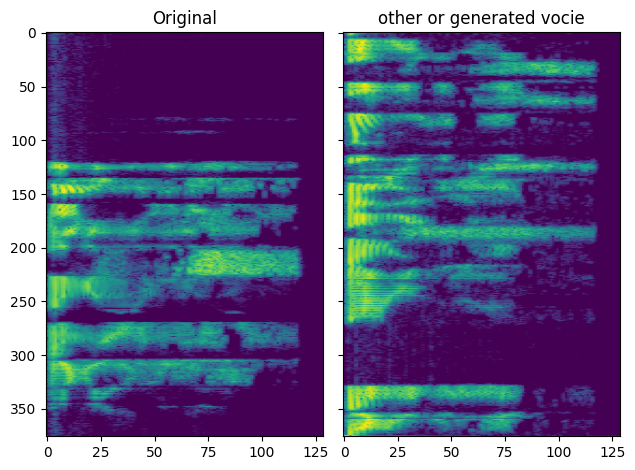

In [104]:
plot_lstm(train_ds[67])

In [105]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=24, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=24, shuffle=True)

In [106]:
def save_model(model, model_name, base_path = './model_save/'):
  model.cpu()
  model.eval()
  torch.save(model, base_path + model_name)

In [107]:
class CrossEntropyLoss(torch.nn.Module):
	def __init__(self):
		super(CrossEntropyLoss, self).__init__()

	def forward(self, output, label):
		label = label.long()
		loss = F.cross_entropy(output, label)
		return loss

In [108]:
class SiameseNetwork(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers):
		super(SiameseNetwork, self).__init__()
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, 512)

		self.final = nn.Linear(512, 2)

	def forward_once(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

	def forward(self, input1, input2):
		output1 = self.forward_once(input1)
		output2 = self.forward_once(input2)
		return self.final(torch.abs(output1 - output2))

In [109]:
num_epochs = 10
siamese_model = SiameseNetwork(input_size=data_size[-1], hidden_size=1024, num_layers=1).to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
from src.trainer.siamese_trainer import evaluate_siamese_model, train_siamese_model
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])


Epoch 1/10, Loss: 0.6872, Accuracy: 0.5322, Precision: 0.5632, Recall: 0.2868, F1: 0.3800


Epoch 1/10, Loss: 0.6678, Accuracy: 0.5536, Precision: 0.6412, Recall: 0.2435, F1: 0.3529


Epoch 2/10, Loss: 0.6519, Accuracy: 0.6144, Precision: 0.6528, Recall: 0.4889, F1: 0.5591


Epoch 2/10, Loss: 0.6425, Accuracy: 0.6609, Precision: 0.6975, Recall: 0.5681, F1: 0.6262


Epoch 3/10, Loss: 0.6267, Accuracy: 0.6513, Precision: 0.6715, Recall: 0.5924, F1: 0.6295


Epoch 3/10, Loss: 0.6301, Accuracy: 0.6797, Precision: 0.6722, Recall: 0.7014, F1: 0.6865


Epoch 4/10, Loss: 0.6063, Accuracy: 0.6743, Precision: 0.6778, Recall: 0.6643, F1: 0.6710


Epoch 4/10, Loss: 0.6134, Accuracy: 0.6899, Precision: 0.6979, Recall: 0.6696, F1: 0.6834


Epoch 5/10, Loss: 0.5822, Accuracy: 0.6946, Precision: 0.6992, Recall: 0.6831, F1: 0.6910


Epoch 5/10, Loss: 0.6092, Accuracy: 0.7087, Precision: 0.7236, Recall: 0.6754, F1: 0.6987


Epoch 6/10, Loss: 0.5634, Accuracy: 0.7111, Precision: 0.7098, Recall: 0.7143, F1: 0.7121


Epoch 6/10, Loss: 0.6088, Accuracy: 0.6841, Precision: 0.6667, Recall: 0.7362, F1: 0.6997


Epoch 7/10, Loss: 0.5527, Accuracy: 0.7219, Precision: 0.7272, Recall: 0.7102, F1: 0.7186


Epoch 7/10, Loss: 0.6073, Accuracy: 0.6797, Precision: 0.6615, Recall: 0.7362, F1: 0.6968


Epoch 8/10, Loss: 0.5469, Accuracy: 0.7273, Precision: 0.7229, Recall: 0.7373, F1: 0.7300


Epoch 8/10, Loss: 0.5817, Accuracy: 0.7130, Precision: 0.6842, Recall: 0.7913, F1: 0.7339


Epoch 9/10, Loss: 0.5535, Accuracy: 0.7189, Precision: 0.7158, Recall: 0.7260, F1: 0.7209


Epoch 9/10, Loss: 0.5890, Accuracy: 0.7174, Precision: 0.7083, Recall: 0.7391, F1: 0.7234


Epoch 10/10, Loss: 0.5420, Accuracy: 0.7322, Precision: 0.7344, Recall: 0.7275, F1: 0.7310


Epoch 10/10, Loss: 0.5829, Accuracy: 0.7188, Precision: 0.7151, Recall: 0.7275, F1: 0.7213


In [111]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")

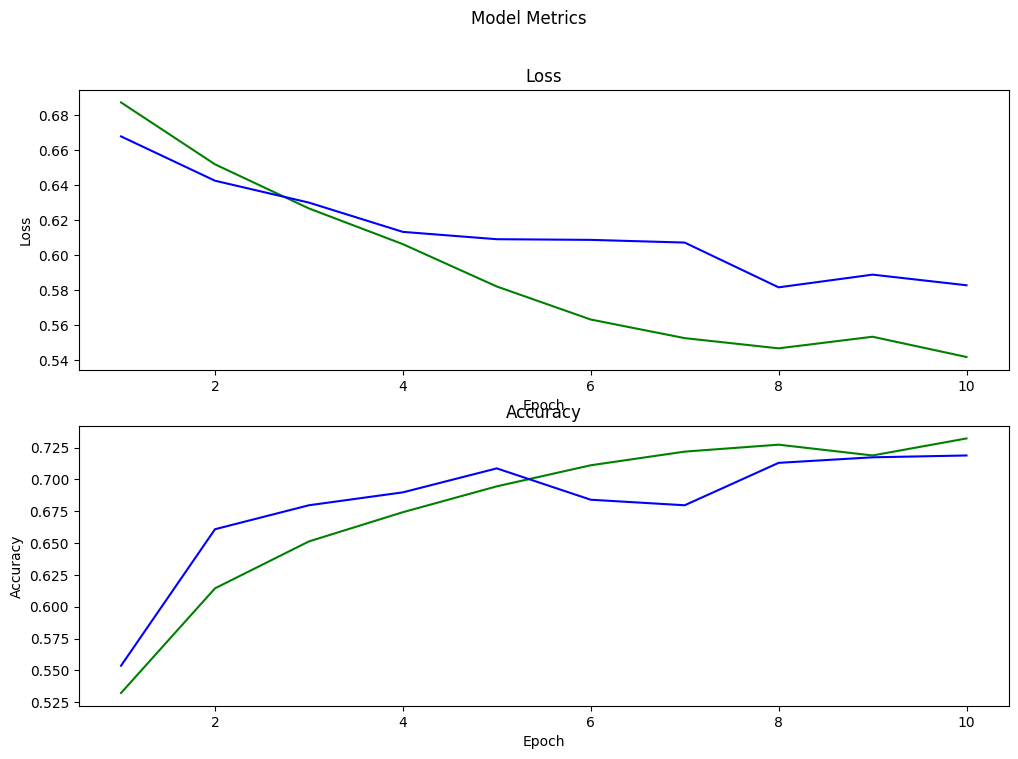

In [112]:
plot_metrix(loss, accuracy)

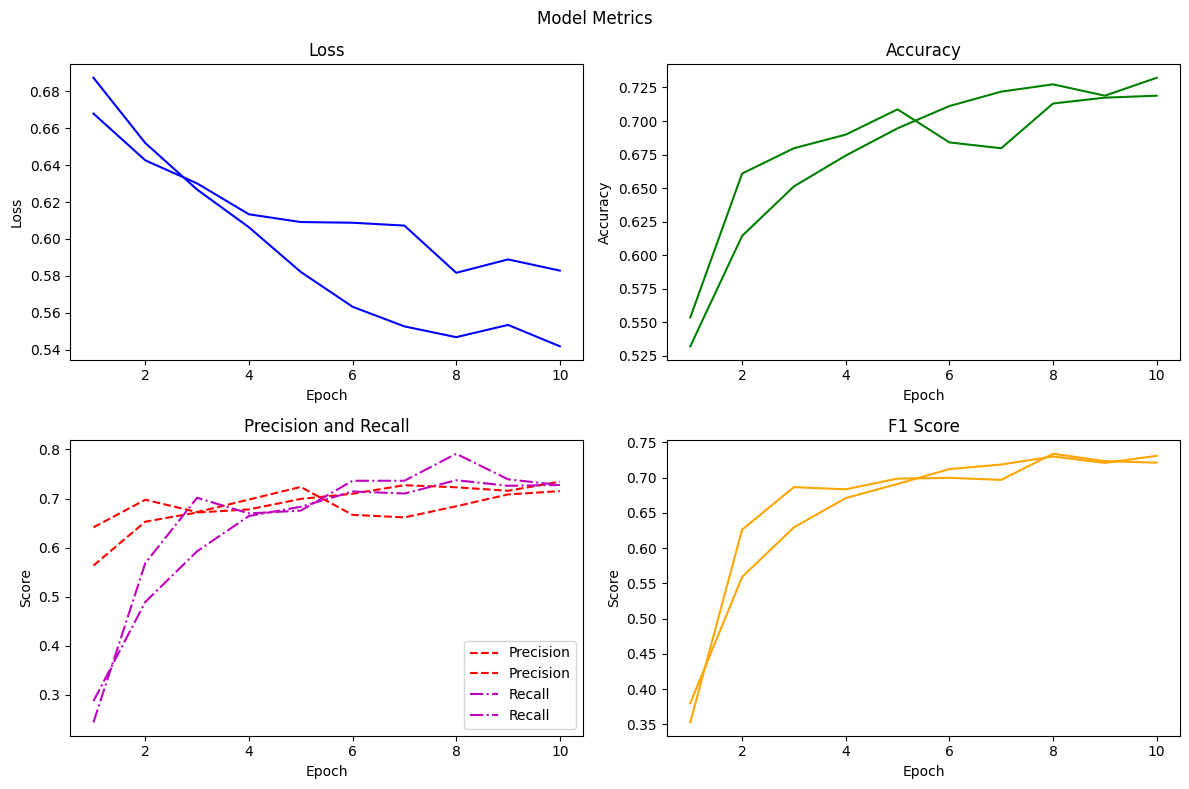

In [113]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)  


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Model Metrics")


axs[0, 0].plot(epochs, loss, label="Loss", color="b")
axs[0, 0].set_title("Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")

axs[0, 1].plot(epochs, accuracy, label="Accuracy", color="g")
axs[0, 1].set_title("Accuracy")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")


axs[1, 0].plot(epochs, precision, label="Precision", color="r", linestyle="--")
axs[1, 0].plot(epochs, recall, label="Recall", color="m", linestyle="-.")
axs[1, 0].set_title("Precision and Recall")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Score")
axs[1, 0].legend()


axs[1, 1].plot(epochs, f1, label="F1 Score", color="orange")
axs[1, 1].set_title("F1 Score")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Score")

plt.tight_layout()
plt.show()

In [114]:
torch.save(siamese_model.to('cpu'), 'my_lstm_b_model.pt')

In [115]:
import matplotlib.pyplot as plt
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad


In [116]:
def plot_explain_siamese_lstm_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad):
	plt.figure(figsize=(5, 4))

	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.tight_layout()
	plt.title("Anchor Sgram Grad")
	plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
			   origin="lower", aspect="auto")
	plt.figure(figsize=(5, 4))
	plt.subplot(1, 2, 1)
	plt.title("PosNeg Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.tight_layout()
	plt.title("PosNeg Sgram Grad")
	plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
			   origin="lower", aspect="auto")
	plt.show()

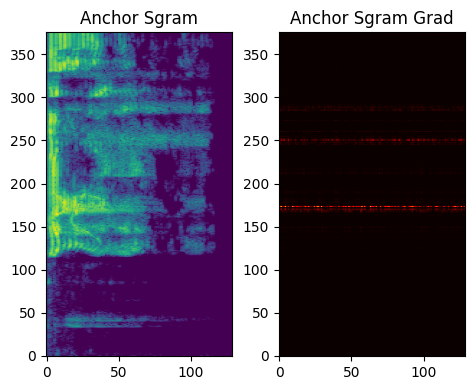

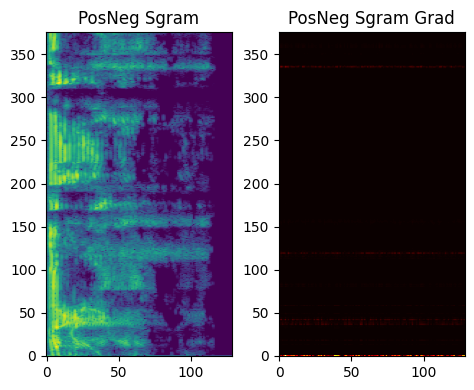

In [117]:
anchor_sgram, posneg_sgram, _ = test_ds[56]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_lstm_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad)

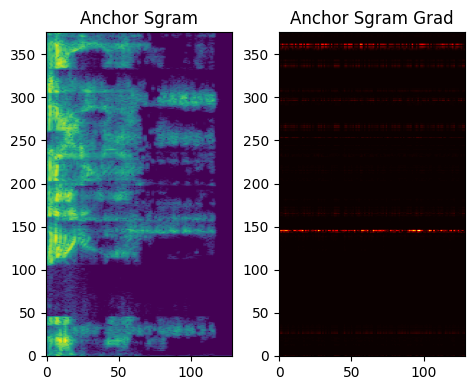

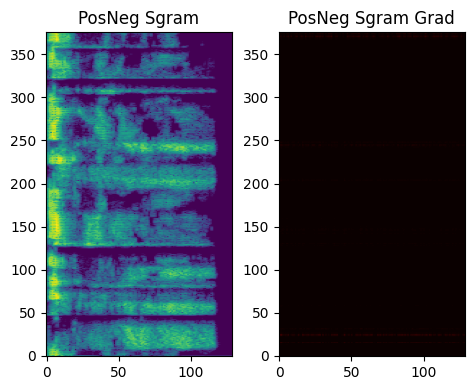

In [118]:
anchor_sgram, posneg_sgram, _ = train_ds[56]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_lstm_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad)

In [119]:
def integrated_gradients(model,anchor_sgram, posneg_sgram, baseline=None, num_steps=10):

	if baseline is None:
		anchor_baseline = torch.zeros_like(anchor_sgram)
		posneg_baseline = torch.zeros_like(posneg_sgram)

	anchor_scaled_inputs = [anchor_baseline + (float(i) / num_steps) * (anchor_sgram - anchor_baseline) for i in range(num_steps + 1)]
	posneg_scaled_inputs = [posneg_baseline + (float(i) / num_steps) * (posneg_sgram - posneg_baseline) for i in range(num_steps + 1)]
	anchor_inputs = torch.stack(anchor_scaled_inputs)
	posneg_inputs = torch.stack(posneg_scaled_inputs)
	anchor_inputs.requires_grad = True
	posneg_inputs.requires_grad = True
	model.zero_grad()
	model.eval()
	model.cpu()
	outputs = model(anchor_inputs, posneg_inputs)

	anchor_prob_predicted_class = torch.softmax(outputs, dim=1)[:, torch.argmax(outputs, dim=1)].sum()

	anchor_gradients = torch.autograd.grad(anchor_prob_predicted_class, anchor_inputs)[0]

	outputs = model(anchor_inputs, posneg_inputs)
	posneg_prob_predicted_class = torch.softmax(outputs, dim=1)[:, torch.argmax(outputs, dim=1)].sum()
	posneg_gradients = torch.autograd.grad(posneg_prob_predicted_class, posneg_inputs)[0]
	anchor_integrated_gradients = (anchor_inputs - anchor_baseline) * anchor_gradients.mean(0)
	posneg_integrated_gradients = (posneg_inputs - anchor_baseline) * posneg_gradients.mean(0)
	anchor_integrated_gradients = torch.mean(anchor_integrated_gradients, dim=0)
	posneg_integrated_gradients =torch.mean(posneg_integrated_gradients, dim=0)
	return anchor_integrated_gradients.detach().numpy(), posneg_integrated_gradients.detach().numpy()

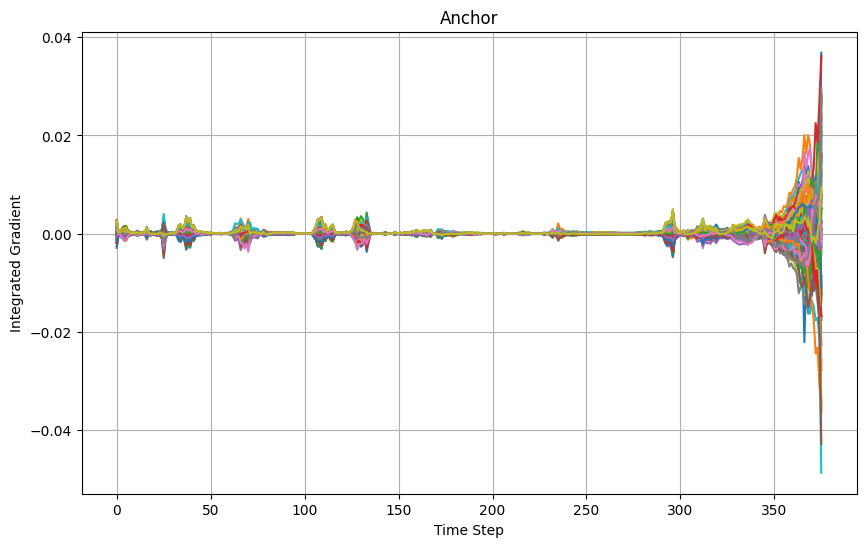

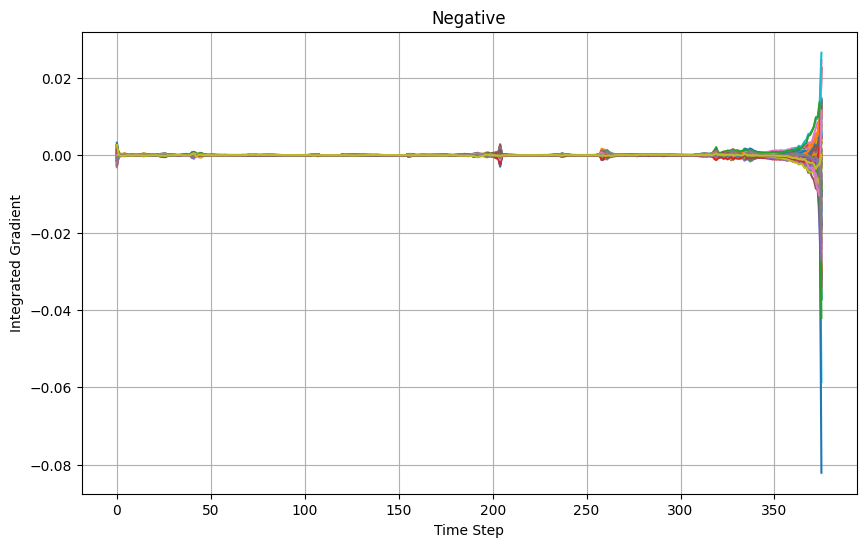

In [120]:
anchor_sgram, posneg_sgram, label = train_ds[56]
anchor_integrated_gradients, posneg_integrated_gradients = integrated_gradients(siamese_model, anchor_sgram, posneg_sgram)
plt.figure(figsize=(10, 6))
for i in range(anchor_integrated_gradients.shape[-1]):
	plt.plot(anchor_integrated_gradients[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Anchor")
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
for i in range(posneg_integrated_gradients.shape[-1]):
	plt.plot(posneg_integrated_gradients[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Positive" if label else "Negative")
plt.grid(True)
plt.show()

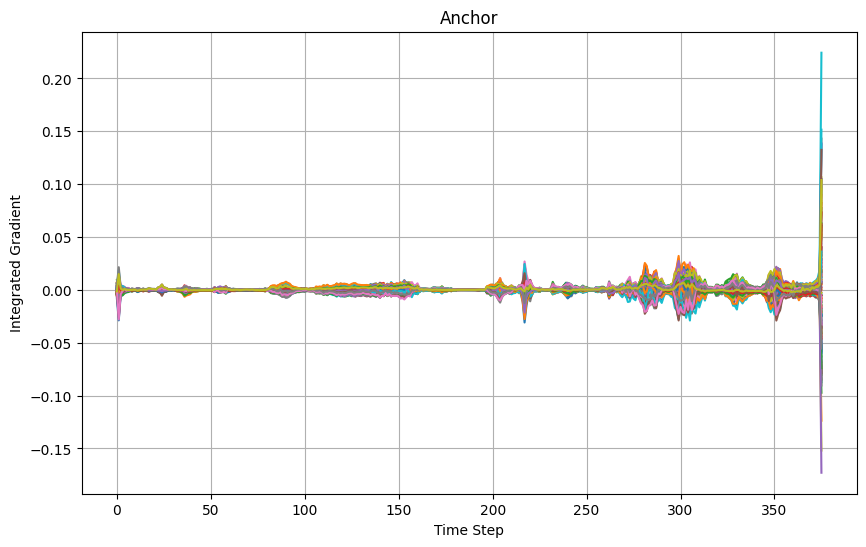

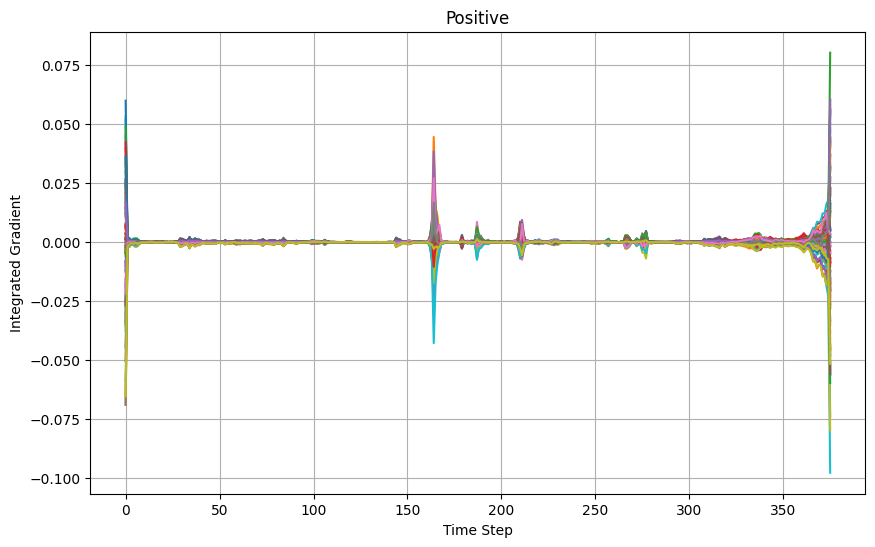

In [121]:
anchor_sgram, posneg_sgram, label = test_ds[56]
anchor_integrated_gradients, posneg_integrated_gradients = integrated_gradients(siamese_model, anchor_sgram, posneg_sgram)
plt.figure(figsize=(10, 6))
for i in range(anchor_integrated_gradients.shape[-1]):
	plt.plot(anchor_integrated_gradients[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Anchor")
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
for i in range(posneg_integrated_gradients.shape[-1]):
	plt.plot(posneg_integrated_gradients[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Positive" if label else "Negative")
plt.grid(True)
plt.show()

In [122]:
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)

In [123]:
from tqdm import tqdm
def test(model, dataloader, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions

In [124]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels =  [ "other","same"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

accuracy: 0.6768115942028986


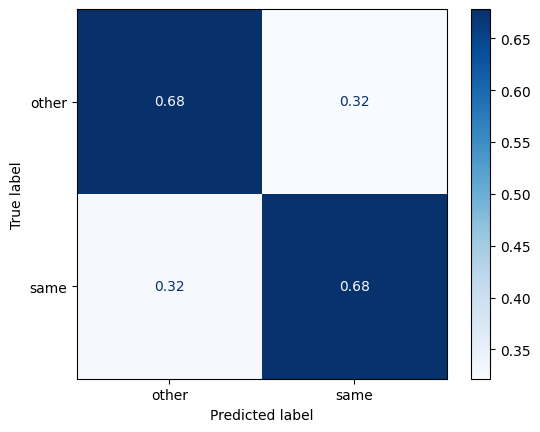

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

accuracy: 0.7188405797101449


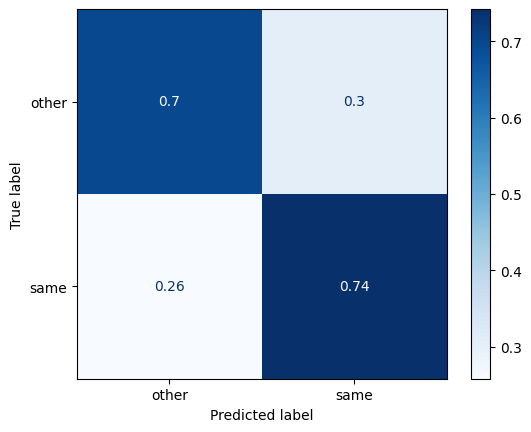

In [126]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [135]:
from src.columns.combined_dataset_column import CombinedDatasetColumn
import librosa

from src.columns.generated_dataset_column import GeneratedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform, AudioToTimeSeriesTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedLSTMSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
					AudioToTimeSeriesTransform( n_fft=256)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

In [136]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedLSTMSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.6781767955801105


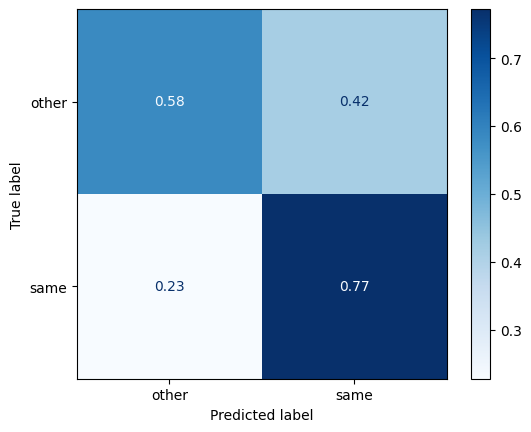

In [137]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [138]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset.csv")
test_ds = CombinedLSTMSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.6434782608695652


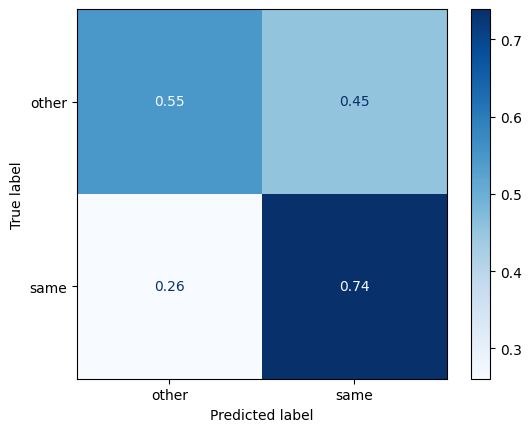

In [139]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [140]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
				AudioToTimeSeriesTransform( n_fft=256)
	]
)
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = CombinedLSTMSoundDS(test_df, DATA_PATH + "validated_16000/",  generated_voice_data_path=None, transform = test_transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.6739130434782609


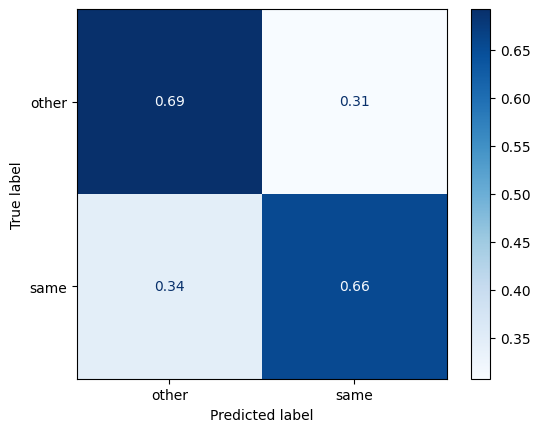

In [141]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [2]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels =  [ "other","same"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()

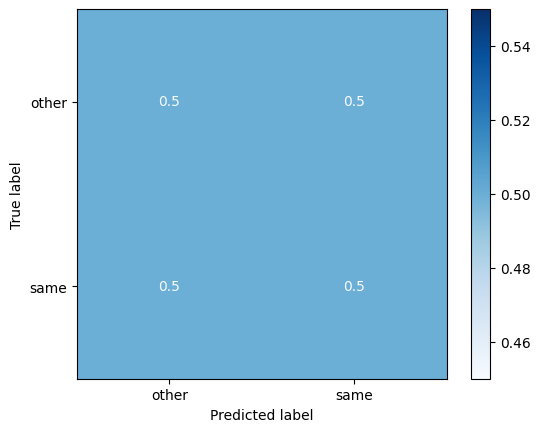

In [3]:
displayConfusionMatrix([1,1,0,0], [1,0,0, 1])